Nome: Raquel Colares Santos

Matrícula: 2022660190

##TP 2 - Aprendizado de Máquina - UFMG
--------------------------------------------------------------------------------

# Implementação do Algoritmo de Boosting

##Introdução

Boosting é  o processo de reduzir o viés de um grande conjunto de modelos simples (i.e., com baixa variância). Esses modelos são chamados de modelos fracos, e são levemente correlacionados com a classifição correta. No processo de Boosting, os modelos fracos formam um modelo mais forte de maneira iterativa. Os modelos fracos são escolhidos iterativamente, de forma que cada modelo é escolhido levando-se em conta viéses independentes. Ou seja,
cada modelo componente realiza erros diferentes de outros modelos componentes.

##Objetivo

O objetivo deste trabalho prático é ganhar experiência com o processo de Boosting. Será implementado o processo de Boosting assumindo um problema de classificação binária com atributos categóricos. Os experimentos utilizarão o dataset tic-tac-toe, disponível em https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame. Será utilizado também a metodologia de validação cruzada com 5 partições e a medida de eficácia a ser considerada é a taxa de erro simples. Todo o processo de Boosting será implementado.  

##Bibliotecas

A seguir temos todas as bibliotecas que serão utilizadas neste trabalho.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import log2, fabs, exp

%matplotlib inline

##Análise de Dados

O dataset que será analizado codifica o conjunto completo de configurações possíveis no final dos jogos da velha, onde se supõe que "x" tenha jogado primeiro.  O conceito de destino é "ganhar por x" (ou seja, verdadeiro quando "x" tem uma das 8 maneiras possíveis de criar um "três em linha"). 
O dataset consiste de 958 opções possíveis, com 9 features de entrada, com 3 valores possíveis ('x', 'o' e 'b') e 2 classificações (positivo quando o jogador um vence e negativo quando o jogador um perde).

As possíveis entradas para o dataset segundo o repositório em questão (UCI Machine Learning Repository) são:

1.   top-left-square: {x,o,b}
2.   top-middle-square: {x,o,b}
3.   top-right-square: {x,o,b}
4.   middle-left-square: {x,o,b}
5.   middle-middle-square: {x,o,b}
6.   middle-right-square: {x,o,b}
7.   bottom-left-square: {x,o,b}
8.   bottom-middle-square: {x,o,b}
9.   bottom-right-square: {x,o,b}
10.  Class: {positive,negative}





In [2]:
# Importando os dados
data = pd.read_csv('/content/tic-tac-toe.data', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [3]:
#Analisando valores nulos
data.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       958 non-null    object
 1   1       958 non-null    object
 2   2       958 non-null    object
 3   3       958 non-null    object
 4   4       958 non-null    object
 5   5       958 non-null    object
 6   6       958 non-null    object
 7   7       958 non-null    object
 8   8       958 non-null    object
 9   9       958 non-null    object
dtypes: object(10)
memory usage: 75.0+ KB


Após analisar os dados foi constatado que não há valores nulos logo não será preciso este tratamento. 
Porém para implementação e execução do modelo Adaboost que será criado, precisa substituir os valores objects por valores numéricos. 

In [5]:
symbol_to_id = {'x': 1, 'o': -1, 'b': 2, 'positive':1, 'negative':-1}
data = data.applymap(lambda x: symbol_to_id[x])

In [6]:
data.head()

,0,1,2,3,4,5,6,7,8,9
0,1,1,1,1,-1,-1,1,-1,-1,1
1,1,1,1,1,-1,-1,-1,1,-1,1
2,1,1,1,1,-1,-1,-1,-1,1,1
3,1,1,1,1,-1,-1,-1,2,2,1
4,1,1,1,1,-1,-1,2,-1,2,1


##Implementação do AdaBoost

O modelo que será implementado será o AdaBoost. Sendo assim será criado a classe AdaBoost e essa por sua vez possui seis métodos. Esses métodos consistem em treino, teste, avaliação do modelo, obter o melhor stump e atualização dos pesos da entrada. 

In [7]:
#Implementando o AdaBoost e definindo suas classes
class AdaBoost():
    def __init__(self):
        pass


    def train(self, data, verbose=False, n_iter=90, min_delta=0.001, patience=10,
              validation=False, validation_set=None):
        self.bweights = [1.0/data.shape[0] for i in range(data.shape[0])]
        self.data = data.values
        self.validation_set = None
        if validation:
            self.validation_set = validation_set.values
        self.alphas = []
        self.stumps = []
        last_accuracy = 0
        cnt_update_accuracy = 0
        train_acc = []
        val_acc = []
        
        while n_iter > 0:
            n_iter -= 1
            best_stump, cur_alpha = self.get_best_stump()
            self.alphas.append(cur_alpha)
            self.stumps.append(best_stump)
            if(self.update_bweights()):
                break
            cur_accuracy = self.evaluate_model(self.data)
            if fabs(cur_accuracy-last_accuracy) < min_delta:
                cnt_update_accuracy += 1
            else:
                last_accuracy = cur_accuracy
                cnt_update_accuracy = 0
            
            train_acc.append(cur_accuracy)
            if validation:
                if not (validation_set is None):
                    val_acc.append(self.evaluate_model(self.validation_set))
            
            if cnt_update_accuracy > patience:
                break
            
            if(verbose):
                if not validation:
                    print('[ #stumps:', len(self.stumps), 'Acurácia de treino:', last_accuracy, ']')
                else:
                    print('[ #stumps:', len(self.stumps), 'Acurácia de treino:', last_accuracy,
                          'Acurácia de validação:', val_acc[-1], ']')
        return train_acc, val_acc


    def test(self, test_data):
        results = []
        for entry in test_data:
            cur_result = 0
            for s_index in range(len(self.stumps)):
                cur_result += self.alphas[s_index]*self.classify_stump(self.stumps[s_index], entry)
            if cur_result < 0:
                results.append(-1)
            else:
                results.append(1)

        return results

    
    def evaluate_model(self, test_data):
        results = self.test(test_data)
        acc = 0
        for i in range(test_data.shape[0]):
            if results[i] == test_data[i][-1]:
                acc += 1
        acc = float(acc) / len(test_data)
        return acc
        

    def classify_stump(self, stump, data_entry):
        f_value = data_entry[stump[0]]
        if f_value == symbol_to_id['x'] and stump[1]:
            return stump[4]
        elif f_value == symbol_to_id['o'] and stump[2]:
            return stump[4]
        elif f_value == symbol_to_id['b'] and stump[3]:
            return stump[4]
        else:
            return -stump[4]


    def get_best_stump(self):
        best_stump = (0, 0, 0, 0, 1)
        best_error = 10000000
        for i in range(9):
            for j in [0, 1]:
                for l in [0, 1]:
                    for m in [0, 1]:
                        for n in [-1, 1]:
                            cur_error = 0
                            cur_stump = (i, j, l, m, n)
                            for k in range(self.data.shape[0]):
                                if self.classify_stump(cur_stump, self.data[k]) != self.data[k][9]:
                                    cur_error += self.bweights[k]
                            if cur_error < best_error:
                                best_error = cur_error
                                best_stump = cur_stump
        alpha = 0.0
        if best_error == 0:
            alpha = 1
        else:
            alpha = log2((1.0-best_error)/best_error)/2.0

        return best_stump, alpha


    def update_bweights(self):
        for i in range(len(self.bweights)):
            exp_sign = self.classify_stump(self.stumps[-1], self.data[i]) * self.data[i][9]
            self.bweights[i] *= exp(-self.alphas[-1]*exp_sign)
        
        z_normalizer = float(sum(self.bweights))
        if (z_normalizer <= 0):
            return True
        for i in range(len(self.bweights)):
            self.bweights[i] /= z_normalizer
        return False

Depois de definida as classes da implementação do modelo AdaBoost, é separado os dados para treino sendo 25% para treino e 75% para validação. Também foi determinado para o treinamento número de SEEDs igual a 42 e serão realizadas 100 iterações. 


In [8]:
#Treinando o AdaBoost
SEED = 42
np.random.seed(SEED)

clf = AdaBoost()

data = data.sample(frac=1, random_state=SEED).reset_index(drop=True)

val_set = data.iloc[:int(0.25*data.shape[0])]
train_set = data.iloc[int(0.25*data.shape[0]):]

train_acc, val_acc = clf.train(data, verbose=True, n_iter=100, validation=True, validation_set=val_set)

[ #stumps: 1 Acurácia de treino: 0.6993736951983298 Acurácia de validação: 0.6861924686192469 ]
[ #stumps: 2 Acurácia de treino: 0.6993736951983298 Acurácia de validação: 0.6861924686192469 ]
[ #stumps: 3 Acurácia de treino: 0.6388308977035491 Acurácia de validação: 0.6569037656903766 ]
[ #stumps: 4 Acurácia de treino: 0.7004175365344467 Acurácia de validação: 0.7112970711297071 ]
[ #stumps: 5 Acurácia de treino: 0.744258872651357 Acurácia de validação: 0.7615062761506276 ]
[ #stumps: 6 Acurácia de treino: 0.7192066805845512 Acurácia de validação: 0.7196652719665272 ]
[ #stumps: 7 Acurácia de treino: 0.6878914405010439 Acurácia de validação: 0.6820083682008368 ]
[ #stumps: 8 Acurácia de treino: 0.7265135699373695 Acurácia de validação: 0.7531380753138075 ]
[ #stumps: 9 Acurácia de treino: 0.744258872651357 Acurácia de validação: 0.7866108786610879 ]
[ #stumps: 10 Acurácia de treino: 0.7588726513569938 Acurácia de validação: 0.7782426778242678 ]
[ #stumps: 11 Acurácia de treino: 0.76304

Depois de implementado e treinado o AdaBoost, será feito a sua avaliação seguindo a metodologia de validação cruzada com 5 partições. 

Pode-se observar que o valor de acurácia encontrado para cada uma das 5 partições foi aproximadamente 98.43%, 96.34%, 98.95%, 98.43% e 96.86% respectivamente. Já a acurácia média do teste encontrada foi 97.80% com desvio padrão de 0.01015. Foi encontrado um ótimo valor para o modelo AdaBoost implementado. 

In [9]:
# Randomizando os dados
data = data.sample(frac=1, random_state=SEED).reset_index(drop=True)

fold_cnt = 1
test_acc = []
i=0
j=-1

step = int(0.2*data.shape[0])
for fold in range(0, data.shape[0], step):
    clf = AdaBoost()
    
    if fold+step > data.shape[0]:
        continue
    
    test_set = data.iloc[fold:fold+step]
    train_set = data.iloc[np.r_[0:fold, (fold+step):data.shape[0]]]
    train_acc, garbage = clf.train(train_set, verbose=False)
    test_acc.append(clf.evaluate_model(test_set.values))
    
    if(j == 1):
        i += 1
        j = 0
    else:
        j += 1
    
    fold_cnt += 1


In [10]:
#Imprimindo os resultados de Acurácia
print('Teste de Acurácia para cada fold:\n', test_acc, '\n')
print('Acurácia média do teste:', np.mean(test_acc))
print('Desvio Padrão da Acurácia do teste:', np.std(test_acc))

Teste de Acurácia para cada fold:
 [0.9842931937172775, 0.9633507853403142, 0.9895287958115183, 0.9842931937172775, 0.9685863874345549] 

Acurácia média do teste: 0.9780104712041885
Desvio Padrão da Acurácia do teste: 0.010152209125479232


Para o modelo AdaBoost implementado foi plotado um gráfico de acurácia pelo número de iterações para análise. Observa-se então que tanto para o valor de treino como para o valor de validação há uma estabilização na acurácia do modelo aproximadamente em torno da 70 iteração. 

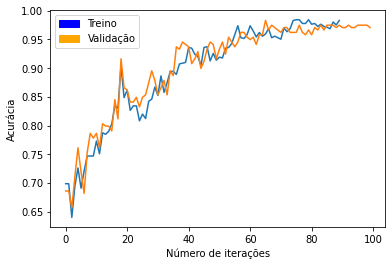

In [11]:
#Plotando os valores de Acurácia pelo número de Iterações
plt.plot(np.arange(len(train_acc)), train_acc, np.arange(len(val_acc)), val_acc)
blue_patch = mpatches.Patch(color='blue', label='Treino')
orange_patch = mpatches.Patch(color='orange', label='Validação')
plt.legend(handles=[blue_patch, orange_patch])
plt.ylabel('Acurácia')
plt.xlabel('Número de iterações')
plt.show()

##Conclusão

Nesse projeto foi utilizado um conjunto de dados do jogo da velha (tic-tac-toe) e foi implementado o algoritmo AdaBoost que corresponde a uma abordagem específica para algortimos de aprendizado de boosting, para um problema de classificação binária com atributos categóricos. Foi realizado a avaliação seguindo a metodologia de validação cruzada com 5 partições.
Os resultados encontraram apresentaram-se bons e altos com uma acurácia média do teste de 97.80% com desvio padrão pequeno de 0.01015 ou 1%. 
Feita a análise gráfica do modelo implatado observou-se que o algoritmo alcançous seu valor máximo de acurácia antes de parar, em torno da 70 iteração. Por meio da combinação de modelos fracos, foi possível obter um modelo forte, sendo possível melhorar o alto viés dos stumps e permanecer com uma baixa variância.

